In [1]:
import h5py
import numpy as np
from scipy.interpolate import griddata

import os, sys
sys.path.append(os.path.split(sys.path[0])[0])
ROOT_DIR = os.path.split(sys.path[0])[0]

Load in vivo LFP

In [2]:
hf = h5py.File(os.path.join(ROOT_DIR, 'data/cell360LFP2D.h5'), 'r')
groundtruth_lfp = np.array(hf.get('data'))
elec_pos = np.array(hf.get('coord'))
xv = np.array(hf.get('grid/x'))
yv = np.array(hf.get('grid/y'))
fs = hf.get('fs')[0]

Interpolate LFP into rectilinear grid

In [3]:
def Grid_LFP(lfp,coord,x,y):
    t = lfp.shape[0]
    xx, yy = np.meshgrid(x,y,indexing='ij')
    grid = np.column_stack((xx.ravel(),yy.ravel()))
    grid_lfp = np.empty((t,grid.shape[0]))
    for i in range(t):
        grid_lfp[i,:] = griddata(coord,lfp[i,:],grid)
    return grid_lfp, grid

In [4]:
grid_lfp, grid = Grid_LFP(groundtruth_lfp,elec_pos,xv,yv)

Plot interpolated LFP in each electrode column

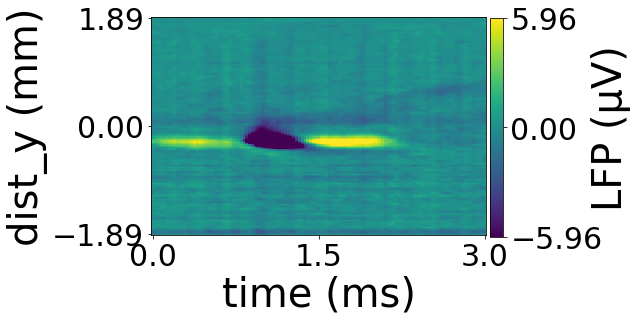

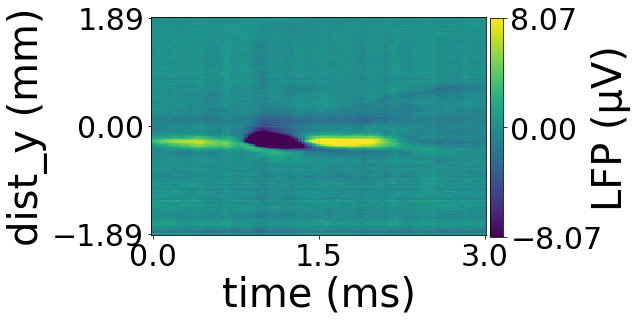

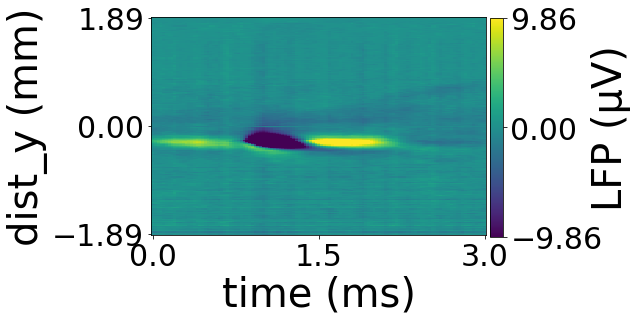

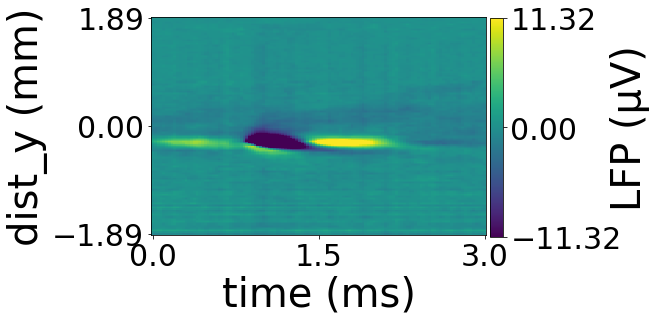

In [5]:
from utils.plotting.plot_results import plot_LFP_heatmap
%matplotlib inline

dt = 1000/fs
t = dt*np.arange(grid_lfp.shape[0])
for x in xv:
    idx = np.nonzero(grid[:,0]==x)[0]
    plot_LFP_heatmap(t,yv,grid_lfp[:,idx])

In [6]:
def Stats(lfp):
    """
    Calculates summary statistics
    """
    lfp = np.asarray(lfp)
    grid_shape = (4,190) # get it from config.params
    
    avg = np.mean(lfp,axis=0) # average voltage of each channel
    stdDev = np.std(lfp,axis=0) # stDev of the voltage of each channel
    tT = np.argmin(lfp,axis=0)
    tP = np.argmax(lfp,axis=0)
    Troughs = -np.take_along_axis(lfp,np.expand_dims(tT,axis=0),axis=0)
    Peaks = np.take_along_axis(lfp,np.expand_dims(tP,axis=0),axis=0)
    relT = tP-tT
    
    stats_list = [avg,relT,stdDev,Troughs,Peaks]
    I_min = 2 # include minimum statistics for the the first I_min in stats_list
    
    # Statistics across channels
    def statscalc(stats,include_min=True):
        """include_min: include minimun value and position"""
        stats = stats.ravel()
        mean = np.mean(stats)
        std = np.std(stats)
        M = np.argmax(stats)
        max_val = stats[M]
        Mx, My = np.unravel_index(M,grid_shape)
        if include_min:
            m = np.argmin(stats)
            min_val = stats[m]
            mx, my = np.unravel_index(m,grid_shape)
            All = np.array([mean,std,Mx,My,max_val,mx,my,min_val])
        else:
            All = np.array([mean,std,Mx,My,max_val])
        return All
    
    allStats = np.concatenate([statscalc(x,i<I_min) for i,x in enumerate(stats_list)])
    return allStats

In [10]:
Stats(grid_lfp)

array([  -0.32513139,    0.59316778,    3.        ,    3.        ,
          1.46395758,    3.        ,   81.        ,   -3.69506715,
         -8.58815789,   43.58440229,    1.        ,   41.        ,
         97.        ,    3.        ,   22.        , -117.        ,
          1.05980038,    2.75387877,    3.        ,   81.        ,
         23.02582597,    3.708033  ,    9.97216488,    3.        ,
         81.        ,   85.97109375,    1.19038716,    2.34133695,
          3.        ,   81.        ,   19.83984375])